# Study of Covid data as published by the NYT

In [76]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
%matplotlib inline

In [77]:
matplotlib.style.use('seaborn-whitegrid')

In [78]:
import geopandas as gpd

In [79]:
import geoplot as gplt
import geoplot.crs as gcrs

Set the style for the graphs

## Get NYT Data and prepare the data

In [80]:
df = pd.read_csv('us-states.csv')
df.tail()

,date,state,fips,cases,deaths
1549,2020-03-30,Virginia,51,1021,26
1550,2020-03-30,Washington,53,5179,221
1551,2020-03-30,West Virginia,54,145,1
1552,2020-03-30,Wisconsin,55,1267,20
1553,2020-03-30,Wyoming,56,95,0


### Make the dates strings into Timestamp objects

In [82]:
df['date']=df['date'].apply(lambda x:pd.Timestamp(x))
df.dtypes

date      datetime64[ns]
state             object
fips               int64
cases              int64
deaths             int64
dtype: object

For easier data slicing based on dates, make the date column the index

In [83]:
df.set_index('date',inplace=True)
df.head()

,state,fips,cases,deaths
date,,,,
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0


### Plot the evolution of number of cases per state

In [114]:
def my_sate_cases_plotter(fig,ax,df,state,column):
    '''
    Helper function to make the graphs
    '''
    fig.set_size_inches(12,8)
    ax.set_title(f"Evolution of cases per State")
    # x locators and formatters
    ax.xaxis.set_major_locator(WeekdayLocator(MONDAY))
    ax.xaxis.set_minor_locator(DayLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%b-%d'))
    ax.xaxis.set_minor_formatter(DateFormatter('%d'))
    # y formatter for thousands separator
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))
    out = ax.plot( df[df['state']==state].loc['20200301':].index , df[df['state']==state].loc['20200301':,[column]],label=state )
    ax.legend()
    return out

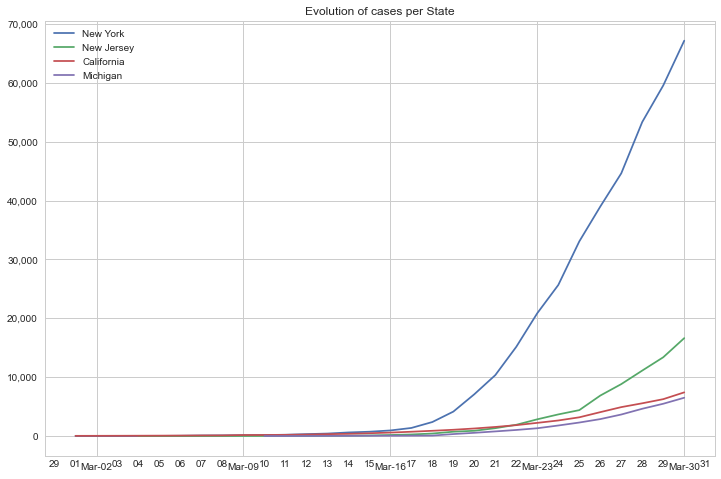

In [115]:
fig,ax = plt.subplots()
my_sate_cases_plotter(fig,ax,df,state='New York',column="cases")
my_sate_cases_plotter(fig,ax,df,state='New Jersey',column="cases")
my_sate_cases_plotter(fig,ax,df,state='California',column="cases")
out = my_sate_cases_plotter(fig,ax,df,state='Michigan',column="cases")

## Sates ranked per number of cases

In [111]:
last_timestamp = df.index.sort_values()[-1]

In [112]:

df[last_timestamp:].sort_values(by='cases',ascending=False).head(10)

,state,fips,cases,deaths
date,,,,
2020-03-30,New York,36,67174,1224
2020-03-30,New Jersey,34,16636,199
2020-03-30,California,6,7421,146
2020-03-30,Michigan,26,6508,197
2020-03-30,Massachusetts,25,5752,61
2020-03-30,Florida,12,5694,71
2020-03-30,Washington,53,5179,221
2020-03-30,Illinois,17,5070,84
2020-03-30,Pennsylvania,42,4156,48


## Number of New Cases per day (for a list of states)

In [197]:
states_list = ["New York","New Jersey","California","Michigan","Massachusetts","Florida","Washington","Illinois","Pennsylvania","Louisiana"]

In [198]:
df_states_list = []

In [199]:
# Iterate over all states, create the df and append to the list
for i,state in enumerate(states_list):
    # create a local copy of the df
    df_state = df[df.state == state].copy()
    # calculate the number of new cases per day
    df_state['new cases'] = df_state['cases'] - df_state['cases'].shift(1)
    df_state.fillna(0,inplace=True)
    # calculate SMA
    df_state['SMA'] = ( df_state['new cases'] + df_state['new cases'].shift(1) + df_state['new cases'].shift(2) )*1/3
    # append the df of that state to the list
    df_states_list.append(df_state)

In [200]:
df_states_list[0].tail()

,state,fips,cases,deaths,new cases,SMA
date,,,,,,
2020-03-26,New York,36,38987,432,5921.0,6037.333333
2020-03-27,New York,36,44635,535,5648.0,6323.333333
2020-03-28,New York,36,53363,782,8728.0,6765.666667
2020-03-29,New York,36,59568,965,6205.0,6860.333333
2020-03-30,New York,36,67174,1224,7606.0,7513.000000


### PLOT OF NEW CASES (for the 4 most impacted states)

In [210]:
def my_new_cases_plotter(df_list,states_list):

    nb_columns_fig = 2
    nb_rows_fig = 5
#     If more than 4 grapghs, extend the rows
#     if len(df_list) > 4:
#         nb_rows_fig = int((np.ceil(len(df_list) / nb_columns_fig)))
    
    fig, ax_arr = plt.subplots(nb_rows_fig, nb_columns_fig)  # create a figure with a 'rows x columns' grid of axes
    fig.set_size_inches(16,20)
    fig.suptitle("New cases registered per day")
    
    for df_index in range(len(df_list)):  # iterate over all the data frames to plot
    
        i_fig = int((np.floor(df_index / nb_columns_fig)))  # row position of the axes on that given figure
        j_fig = int((df_index % nb_columns_fig))  # column position of the axes on that given figure

        df = df_list[df_index].loc['20200301':]  # df to plot at that position

        ax_arr[i_fig,j_fig].bar(x=df['new cases'].index,height=df['new cases'],color="#900C3F")
        ax_arr[i_fig,j_fig].plot(df['new cases'].index,df['SMA'],color="#FFC300")

        ax_arr[i_fig,j_fig].xaxis.set_major_locator(WeekdayLocator(MONDAY))
        ax_arr[i_fig,j_fig].xaxis.set_minor_locator(DayLocator())
        ax_arr[i_fig,j_fig].xaxis.set_major_formatter(DateFormatter('%b-%d'))
        #ax_arr[i_fig,j_fig].xaxis.set_minor_formatter(DateFormatter('%d'))
        ax_arr[i_fig,j_fig].set_title(states_list[df_index])
        

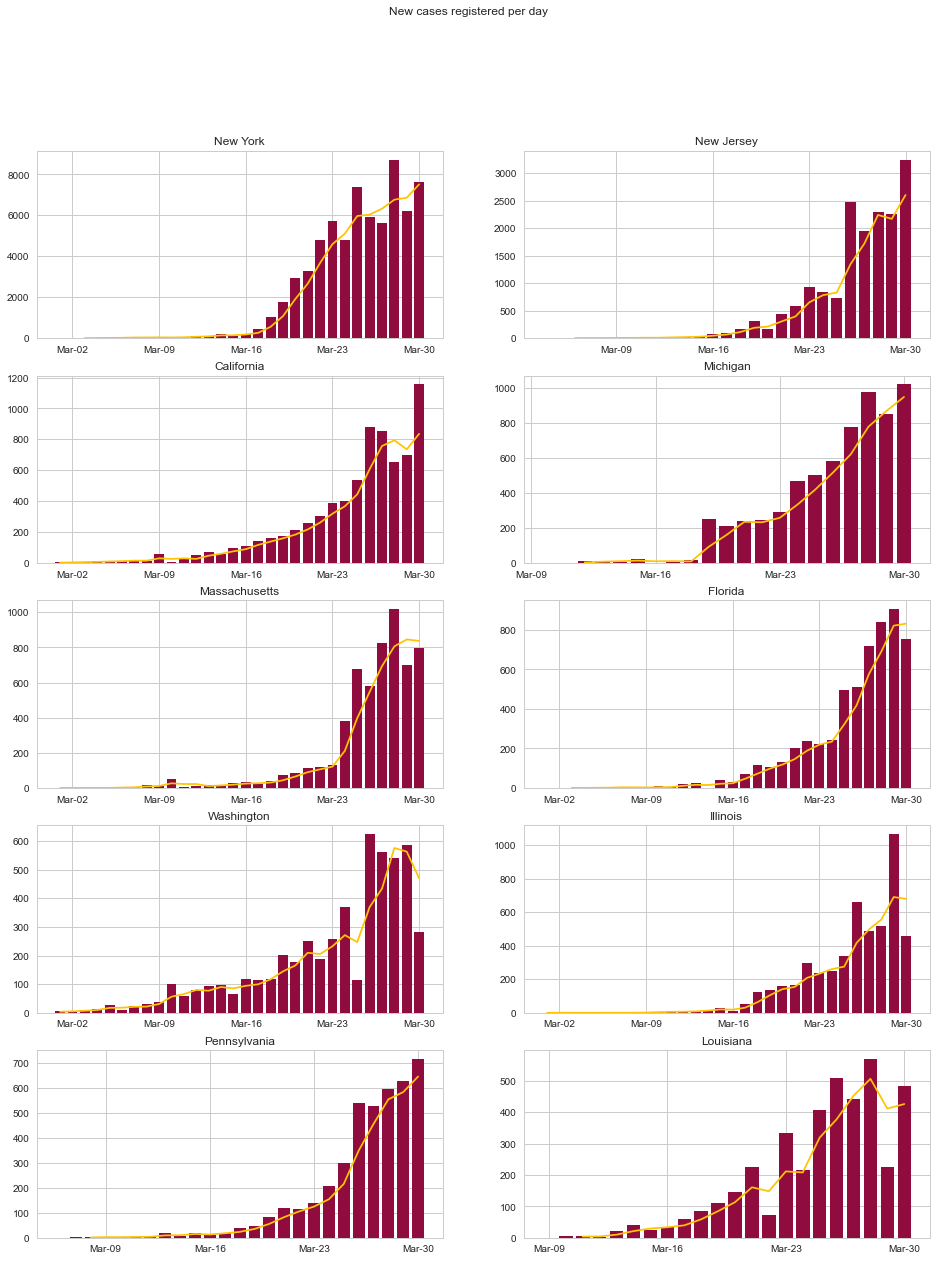

In [211]:
my_new_cases_plotter(df_states_list,states_list)

## GEO VISUALIZATON

In [90]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')

### USA States

In [91]:
contiguous_usa.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."
3,Idaho,USA-3518,1567582,"POLYGON ((-111.04973 44.48816, -111.05025 42.0..."
4,Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1..."


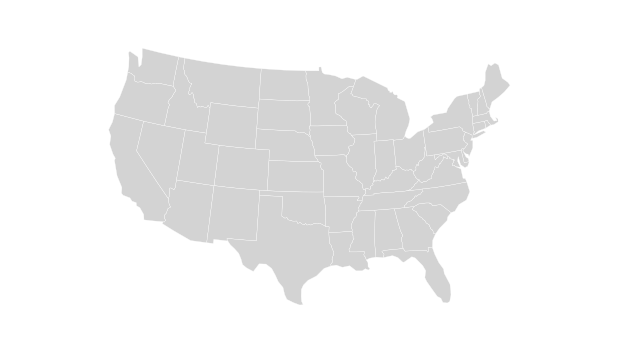

In [92]:
# USA Country map
ax = gplt.polyplot(contiguous_usa,projection=gcrs.AlbersEqualArea(),figsize=(11,8),
                  edgecolor='white',facecolor='lightgray')

### USA States center point (centroid of the polygon)

In [93]:
states_centroids = contiguous_usa.copy()

In [94]:
states_centroids['geometry'] = states_centroids['geometry'].apply(lambda x:x.centroid,)
states_centroids.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,POINT (-94.17744 46.36007)
1,Montana,USA-3515,989415,POINT (-109.65900 47.04846)
2,North Dakota,USA-3516,672591,POINT (-100.48470 47.46271)
3,Idaho,USA-3518,1567582,POINT (-114.65497 44.39401)
4,Washington,USA-3519,6724540,POINT (-120.39837 47.37975)


### Preparing data for Geo visualization

In [95]:
states_centroids.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,POINT (-94.17744 46.36007)
1,Montana,USA-3515,989415,POINT (-109.65900 47.04846)
2,North Dakota,USA-3516,672591,POINT (-100.48470 47.46271)
3,Idaho,USA-3518,1567582,POINT (-114.65497 44.39401)
4,Washington,USA-3519,6724540,POINT (-120.39837 47.37975)


In [96]:
geodata = pd.merge(left=df,right=states_centroids,how='inner',on='state',right_index=True)
geodata.loc['20200328'].sort_values(by='fips').head()

,state,fips,cases,deaths,adm1_code,population,geometry
date,,,,,,,
2020-03-28,Alabama,1,720,4,USA-3541,4779736,POINT (-86.82818 32.77371)
2020-03-28,Arizona,4,773,15,USA-3520,6392017,POINT (-111.65946 34.29560)
2020-03-28,Arkansas,5,409,5,USA-3528,2915918,POINT (-92.44486 34.92181)
2020-03-28,California,6,5565,121,USA-3521,37253956,POINT (-119.64054 37.25514)
2020-03-28,Colorado,8,2061,44,USA-3522,5029196,POINT (-105.54544 39.00008)


In [97]:
geodata = gpd.GeoDataFrame(geodata)

### Plotting States centroids on the USA Map

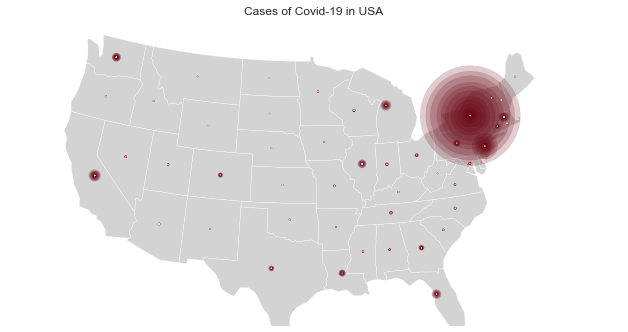

In [98]:
# USA Country map
ax = gplt.polyplot(contiguous_usa,projection=gcrs.AlbersEqualArea(),figsize=(11,8),
                  edgecolor='white',facecolor='lightgray')

# Points per State
gplt.pointplot(
    geodata, ax=ax, hue='cases', cmap='Reds', alpha=0.2,
    scheme='quantiles',
    scale='cases', limits=(1, 100)
)

title_text = ax.set_title('Cases of Covid-19 in USA')